## First attempt at a U-NET

So a UNET has three phases: contraction, bottleneck and expansion.

**Contraction**  
- Consists of repeated application of two 3x3 convolutions (unpadded), each followed by RELU-activation and then a (2x2) max pooling with stride 2.
- At each downsampling we double the number of feature channels.

**Bottleneck**

**Expansion**
- Consists of an upsampling of feature map followed by a 2x2 convolution, a concatenation with the corresponding cropped feature map from the conraction part and two 3x3 convolutions each followed by RELU-activation.
- Halves the number of feature samples.

**Final Layer**
- 1x1 convolution to obtain desired number of classes. For us only 2 (road, not road)

In [1]:
%matplotlib inline
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
import os,sys
from PIL import Image

In [2]:
from src.helpers import load_image, img_float_to_uint8, concatenate_images, img_crop

In [3]:
def shape_training_data(imgs, gt_imgs):
    n = len(imgs)
    #imgs = [imgs[i][:, :, 0] for i in range(n)]
    #imgs = [imgs[i].reshape(400, 400, 1) for i in range(n)]
    gt_imgs = [gt_imgs[i].reshape(400, 400, 1) for i in range(n)]

    return np.asarray(imgs), np.asarray(gt_imgs)

def load_training_data(datapath, num_samples):
    
    image_dir = datapath + "images/"
    files = os.listdir(image_dir)
    n = min(num_samples, len(files)) # Load maximum 20 images
    
    print("Loading " + str(n) + " images")
    imgs = [load_image(image_dir + files[i]) for i in range(n)]

    gt_dir = datapath + "groundtruth/"
    print("Loading " + str(n) + " images")
    gt_imgs = [load_image(gt_dir + files[i]) for i in range(n)]

    return shape_training_data(imgs, gt_imgs)


    

In [4]:
x, y = load_training_data('data/training/', 10)

x_tr = x[0:3, :, : , :]
x_te = x[3:5, :, : , :]

y_tr = y[0:3, :, : , :]
y_te = y[3:5, :, : , :]
x_tr.shape, y_tr.shape, x_te.shape, y_te.shape

Loading 10 images
Loading 10 images


((3, 400, 400, 3), (3, 400, 400, 1), (2, 400, 400, 3), (2, 400, 400, 1))

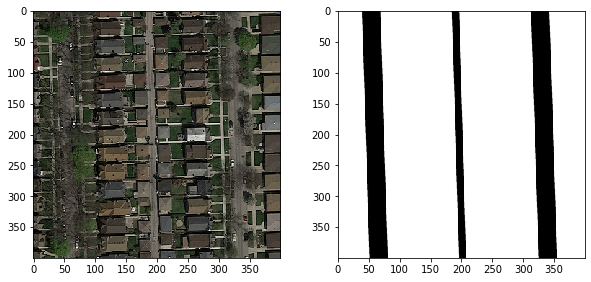

In [22]:
plt.figure(figsize = (10, 10))
plt.subplot(2,2,1)
plt.imshow(x_tr[0])

plt.subplot(2,2,2)
plt.imshow(y_tr[0].reshape(400, 400), cmap="Greys")

In [5]:
from keras.layers import Conv2D, MaxPool2D, UpSampling2D, Concatenate, Input


def contraction_block(x, filters, kernel_size = (3, 3), padding = 'same', strides = 1):
    
    c = Conv2D(filters, kernel_size, padding= padding, strides= strides, activation= 'relu')(x)
    c = Conv2D(filters, kernel_size, padding= padding, strides= strides, activation= 'relu')(c)
    p = MaxPool2D((2,2), (2,2))(c)
    return c, p

def expansion_block(x, skip, filters, kernel_size = (3, 3), padding = 'same', strides = 1):
    us = UpSampling2D((2, 2))(x)
    concat = Concatenate()([us, skip])
    c = Conv2D(filters, kernel_size, padding= padding, strides= strides, activation= 'relu')(concat)
    c = Conv2D(filters, kernel_size, padding= padding, strides= strides, activation= 'relu')(c)
    
    return c

def bottleneck(x, filters, kernel_size = (3, 3), padding = 'same', strides = 1):
    c = Conv2D(filters, kernel_size, padding= padding, strides= strides, activation= 'relu')(x)
    c = Conv2D(filters, kernel_size, padding= padding, strides= strides, activation= 'relu')(c)
    return c
    

Using TensorFlow backend.


In [6]:

from keras.models import Model

def UNET():
    f = [50, 100, 200, 400, 800]
    inputs = Input((400, 400, 3))
    p0 = inputs
    
    c1, p1 = contraction_block(p0, f[0])
    c2, p2 = contraction_block(p1, f[1])
    c3, p3 = contraction_block(p2, f[2])
    c4, p4 = contraction_block(p3, f[3])
    
    bn = bottleneck(p4, f[4])
    
    u1 = expansion_block(bn, c4, f[3])
    u2 = expansion_block(u1, c3, f[2])
    u3 = expansion_block(u2, c2, f[1])
    u4 = expansion_block(u3, c1, f[0])
    
    output = Conv2D(1, (1,1), padding="same", activation='sigmoid')(u4)
    model = Model(inputs, output)
    
    return model


In [7]:
model = UNET()
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ["acc"])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 400, 400, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 400, 400, 50) 1400        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 400, 400, 50) 22550       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 200, 200, 50) 0           conv2d_2[0][0]                   
____________________________________________________________________________________________

In [40]:
model.fit(x=x_tr, y = y_tr,  validation_data =(x_te, y_te), epochs=2)

Train on 3 samples, validate on 2 samples
Epoch 1/2
3/3 [==============================] - 184s 61s/step - loss: 0.6888 - acc: 0.7660 - val_loss: 0.6586 - val_acc: 0.7435
Epoch 2/2
3/3 [==============================] - 194s 65s/step - loss: 0.6588 - acc: 0.7951 - val_loss: 0.5890 - val_acc: 0.7435


In [ ]:
model.save_weights("UNET_FIRSTTRY.h5")

In [8]:
model.load_weights("UNET_FIRSTTRY.h5")

OSError: Unable to open file (bad object header version number)